## Importing dependencies 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_26064\579097343.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading Dataset 

In [2]:
Dataset=pd.read_csv("mnist_train.csv/mnist_train.csv")
images=np.array(Dataset)

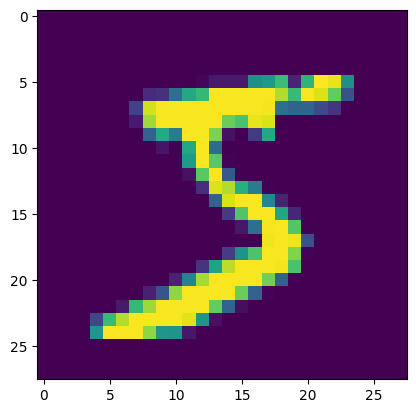

In [3]:
sample=images[0]

y_unencoded=sample[0]

x=sample[1:].reshape((28,28))
x=x/255
plt.gray
plt.imshow(x,interpolation="nearest")
plt.show()

In [4]:
y_unencoded

5

# Designing 1 Epoch 

## Convolutional layer feed forward

In [25]:
%run CNN_functions_library.ipynb

In [26]:
filters={}
(filters[1],filters[2],filters[3],filters[4],filters[5],filters[6],filters[7],filters[8],filters[9],filters[10])=init_filters()

In [27]:
filters[1].shape

(5, 5)

In [28]:
#creating a dictionary to store parameters required for access 
skeleton={}

In [29]:
result={}
Output={}
for i in range(1,11):
    result[i],skeleton[i],Output[i]=convolution_epoch(x,filters[i])

In [30]:
skeleton[1].shape

(26, 26)

In [31]:
cnn_op=np.concatenate(list(result.values()),axis=0)
cnn_op.shape

(1690, 1)

## Dense layer feed forward

In [32]:
scaled=minmax_scaler(cnn_op)
w1,b1,w2,b2=initialize_weights()
z1,a1,z2,a2=forward(scaled,w1,b1,w2,b2)

## Dense layer back prop

In [33]:
dc_w1,dc_b1,dc_w2,dc_b2,dc_x=back_prop(y_unencoded,scaled,z1,a1,z2,a2)
w1,b1,w2,b2=update_params(0.45,dc_w1,dc_b1,dc_w2,dc_b2,w1,b1,w2,b2)
print(w1.shape,b1.shape,w2.shape,b2.shape)

(10, 1690) (10, 1) (10, 10) (10, 1)


## Convolutional Layer back prop

In [22]:
#gradient wrt Input layer of dense layer
dc_x

array([[-0.01232942],
       [-0.03187447],
       [ 0.12705995],
       ...,
       [ 0.05685228],
       [ 0.14706031],
       [-0.33838637]])

In [15]:
flatLayer_grad={}
for i in range(0,10):
    flatLayer_grad[i+1]=dc_x[169*i:169*(i+1)]

In [16]:
flatLayer_grad[10].shape

(169, 1)

In [17]:
poolLayer_grad={}
for i in range(1,11):
    poolLayer_grad[i]=flatLayer_grad[i].reshape((13,13))

In [18]:
poolLayer_grad[1].shape

(13, 13)

In [19]:
A_grad={}
for i in range(1,11):
    A_grad[i]=undo_maxpool(poolLayer_grad[i],skeleton[i])

In [20]:
A_grad[1].shape

(26, 26)

In [21]:
O_grad={}
for i in range(1,11):
    O_grad[i]=A_grad[i]*relu_der(Output[i])

In [22]:
Output[10].shape,O_grad[10].shape

((26, 26), (26, 26))

In [23]:
f_grad={}
for i in range(1,11):
    f_grad[i]=convolve(x,O_grad[i],padding=1,stride=1)
    #here we use padding=1 because in the convolutional layer we'd used padding=1 .
f_grad[10]

array([[-1.43619683, -0.99879133, -0.94427567, -0.23894797,  0.49387104],
       [-0.35563549, -0.32187829, -0.1118949 ,  0.07261389,  0.02744725],
       [ 0.03584751,  0.26125494, -0.1822042 , -0.30496234, -0.85049836],
       [-0.1287254 ,  0.3196826 ,  0.57932011, -0.17208097, -0.33707758],
       [-0.36433589,  0.08588069,  0.36676607,  0.06710942, -0.08852638]])

In [24]:
f_grad[10].shape

(5, 5)

In [25]:
alpha=0.45
for i in range(1,11):
    filters[i]=filters[i]-(alpha*f_grad[i])

In [30]:
a2.shape

(10, 1)

In [32]:
encoded(y_unencoded)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

### 1 Convolutional Back prop run condensed 

In [26]:
flatLayer_grad,poolLayer_grad,A_grad,O_grad,f_grad={},{},{},{},{}
for i in range(1,11):
    flatLayer_grad[i]=dc_x[169*(i-1):169*i]
    poolLayer_grad[i]=flatLayer_grad[i].reshape((13,13))
    A_grad[i]=undo_maxpool(poolLayer_grad[i],skeleton[i])
    O_grad[i]=A_grad[i]*relu_der(Output[i])
    f_grad[i]=convolve(x,O_grad[i],padding=1,stride=1)
    #here we use padding=1 because in the convolutional layer we'd used padding=1 .
    filters[i]=filters[i]-(alpha*f_grad[i])

In [27]:
flatLayer_grad[1].shape,poolLayer_grad[1].shape,A_grad[1].shape,O_grad[1].shape,f_grad[1].shape,filters[1].shape

((169, 1), (13, 13), (26, 26), (26, 26), (5, 5), (5, 5))

# Desinging training loop

In [4]:
%run CNN_functions_library.ipynb

def forward_pass(x,w1,b1,w2,b2,filters):
    result,Output,skeleton={},{},{}
    for i in range(1,11):
            result[i],skeleton[i],Output[i]=convolution_epoch(x,filters[i])
    cnn_op=np.concatenate(list(result.values()),axis=0)
    scaled=minmax_scaler(cnn_op)
    z1,a1,z2,a2=forward(scaled,w1,b1,w2,b2)
    return  z1,a1,z2,a2,Output,skeleton,scaled

def backward_pass(y_unencoded,scaled,z1,a1,z2,a2,Output,skeleton,w1,b1,w2,b2,filters,alpha_c=0.0001,alpha=0.001):
    flatLayer_grad,poolLayer_grad,A_grad,O_grad,f_grad={},{},{},{},{}

    #FCL Back prop
    dc_w1,dc_b1,dc_w2,dc_b2,dc_x=back_prop(y_unencoded,scaled,z1,a1,z2,a2)
    w1,b1,w2,b2=update_params(alpha,dc_w1,dc_b1,dc_w2,dc_b2,w1,b1,w2,b2)

    #CNN Layer back prop
    for i in range(1,11):
        flatLayer_grad[i]=dc_x[169*(i-1):169*i]
        poolLayer_grad[i]=flatLayer_grad[i].reshape((13,13))
        A_grad[i]=undo_maxpool(poolLayer_grad[i],skeleton[i])
        O_grad[i]=A_grad[i]*relu_der(Output[i])
        f_grad[i]=convolve(x,O_grad[i],padding=1,stride=1)
        #here we use padding=1 because in the convolutional layer we'd used padding=1 .
        filters[i]=filters[i]-(alpha_c*f_grad[i])

    return w1,b1,w2,b2,filters

### Initializing filters and weights

In [41]:
filters={}
(filters[1],filters[2],filters[3],filters[4],filters[5],filters[6],filters[7],filters[8],filters[9],filters[10])=init_filters(rs=42)
w1,b1,w2,b2=initialize_weights(rs=42)
filters[2].max()

1.8522781845089378

### Creating a custom training loop

In [5]:
#running epochs on a single image
def train_individual(x,y_unencoded,w1,b1,w2,b2,filters,epochs=10):
    print("epoch: ",end=" ")
    for i in range(epochs):
        z1,a1,z2,a2,Output,skeleton,scaled=forward_pass(x,w1,b1,w2,b2,filters)
        w1,b1,w2,b2,filters=backward_pass(y_unencoded,scaled,z1,a1,z2,a2,Output,skeleton,w1,b1,w2,b2,filters,alpha_c=0.001,alpha=0.001)
        print(i,end=" ")
    print("\n")
    #print("Filters: ",filters)
    return w1,b1,w2,b2,filters

In [6]:
#running training loop on multiple images 
def training_loop(images,w1,b1,w2,b2,filters):
    for i in range(images.shape[0]):
        print("image: ",i)
        
        sample=images[i]
        y_unencoded=sample[0]
        x=sample[1:].reshape((28,28))
        x=x/255
        w1,b1,w2,b2,filters=train_individual(x,y_unencoded,w1,b1,w2,b2,filters,epochs=10)
        #print("Filters: ",filters)
    return w1,b1,w2,b2,filters

In [7]:
#saving parameters every 1000 images 
def checkpoint(w1,b1,w2,b2,filters):
    #saving filters after every 1000 images 
    fh=open("Filters_checkpoint.pkl",'wb')
    pickle.dump(filters,fh)
    #saving weights after every 1000 images 
    params={}
    params['w1'],params['b1'],params['w2'],params['b2']=w1,b1,w2,b2
    fh=open("weights_checkpoint.pkl",'wb')
    pickle.dump(params,fh)
    print("checkpoint saved")

In [8]:
def retrieve_checkpoint():   
    fh=open("Filters_checkpoint.pkl",'rb')
    filters_reloaded=pickle.load(fh)
    
    fh=open("weights_checkpoint.pkl",'rb')
    params=pickle.load(fh)
    w1_reloaded,b1_reloaded,w2_reloaded,b2_reloaded=params['w1'],params['b1'],params['w2'],params['b2']
    
    return w1_reloaded,b1_reloaded,w2_reloaded,b2_reloaded,filters_reloaded
    

In [9]:
def get_output(sample,w1,b1,w2,b2,filters):
    #sample is a single row containing the label as the first element and the rest of the 784 columns are pixel values 
    x=sample[1:].reshape((28,28))
    x=x/255
    _,_,_,a2,_,_,_=forward_pass(x,w1,b1,w2,b2,filters)
    prediction=np.argmax(a2)
    return prediction,a2

### Training the model in batches while saving checkpoints 

In [10]:
images.shape #60,000 samples detected! 

(60000, 785)

In [11]:
train=images[:48000,:]
test=images[48000:,:]
train.shape,test.shape

((48000, 785), (12000, 785))

In [ ]:
#this  is how it should have trained if my laptop weren't computationally constrained
for i in range(train.shape[0]//1000):
    batch=train[i*1000:(i+1)*1000,:]
    w1,b1,w2,b2,filters=training_loop(batch,w1,b1,w2,b2,filters)
    checkpoint(w1,b1,w2,b2,filters)

In [78]:
batch=train[47001:,:]
w1,b1,w2,b2,filters=training_loop(batch,w1,b1,w2,b2,filters)
checkpoint(w1,b1,w2,b2,filters)

image:  0
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  1
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  2
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  3
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  4
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  5
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  6
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  7
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  8
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  9
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  10
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  11
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  12
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  13
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  14
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  15
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  16
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  17
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  18
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  19
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  20
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  21
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  22
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  23
epoch:  0 1 2 3 4 5 6 7 8 9 

image:  24
epoch:  0 1 2 3

In [ ]:
# visializing the filters learnt
for i in range(1,11):
    plt.gray
    plt.imshow(filters[i],interpolation="nearest")
    plt.show()

In [46]:
#retrieving the saved checkpoints of trainable parameters
w1,b1,w2,b2,filters=retrieve_checkpoint()
w1.shape,b1.shape,w2.shape,b2.shape,filters

((10, 1690),
 (10, 1),
 (10, 10),
 (10, 1),
 {1: array([[ 0.87255799,  1.33269235,  2.73004239,  3.35125492,  2.18791244],
         [ 0.02694274,  1.77367552,  1.39652768, -0.04712384,  1.00550773],
         [-2.07460619, -2.14476299, -1.41525828, -4.04764543, -3.02260617],
         [-3.16504459, -2.9263093 , -1.34351701, -1.21581517,  0.09071368],
         [ 1.53820744,  0.9879059 ,  1.10220638, -0.12292394,  2.54416506]]),
  2: array([[ 0.04610925, -1.26514888,  0.28655776, -0.60855797, -0.191714  ],
         [-0.60046922,  1.858879  ,  0.02161723, -1.11566702,  0.63005754],
         [-1.40371376, -0.07234777, -2.04003929, -1.31568889,  0.0755482 ],
         [ 0.54784987, -0.32950923, -0.51575247, -0.51573843, -1.78247596],
         [-1.78652622, -1.59723345,  0.13278474, -0.34096163, -2.40390732]]),
  3: array([[ 1.94261147,  0.63732326, -2.69577388,  0.11198707, -1.93915979],
         [ 2.82193967,  0.13848128, -2.98851469, -0.38899842,  1.04879844],
         [-1.46189368,  1.10489

In [ ]:
#Testing out predictions
input=images[7082]
prediction,_=get_output(input,w1,b1,w2,b2,filters)
print("Input Image: ",input[0],"\nprediction: ",prediction)

In [14]:
def calculate_accuracy(batch,w1,b1,w2,b2,filters):
    predictions_list=[]
    actual_labels=[]

    #getting the predictions for the samples in the given batch and populating predictions_list
    for i in range(batch.shape[0]):

        #getting the prediction 
        input=batch[i]
        prediction,_=get_output(input,w1,b1,w2,b2,filters) #takes in a row ( with label as input )
        
        #adding predictions and actual labels to a list
        predictions_list.append(prediction)
        actual_labels.append(input[0])

    correct_predictions=0
    for i in range(len(predictions_list)):
        if predictions_list[i]==actual_labels[i]:
            correct_predictions+=1

    #print(predictions_list,"\n",actual_labels)

    accuracy=correct_predictions/batch.shape[0]
            
    return accuracy
        

In [79]:
calculate_accuracy(test[:1000,:],w1,b1,w2,b2,filters)

0.88

In [76]:
accuracy={}
accuracy[10000]=0.82
accuracy[12000]=0.82
accuracy[14000]=0.835
accuracy[16000]=0.8075
accuracy[18000]=0.8325
accuracy[20000]=0.8575
accuracy[22000]=0.8325
accuracy[24000]=0.855
accuracy[26000]=0.845
accuracy[28000]=0.855
accuracy[30000]=0.865
accuracy[32000]=0.8425
accuracy[35000]=0.885
accuracy[38000]=0.86
accuracy[41000]=0.891
accuracy[44000]=0.895
accuracy[47000]=0.894
accuracy[48000]=0.

Text(0, 0.5, 'Accuracy score')

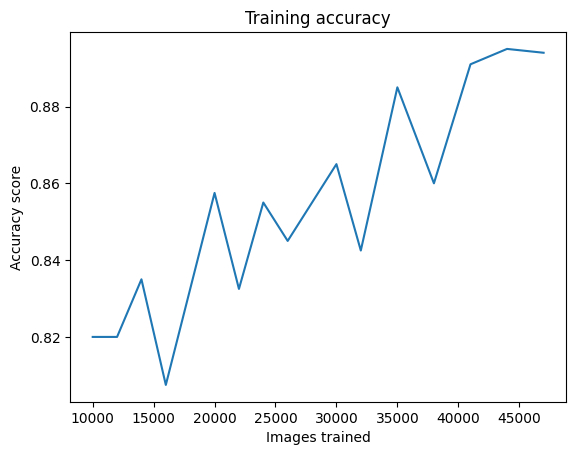

In [77]:
plt.plot(accuracy.keys(),accuracy.values())
plt.title("Training accuracy")
plt.xlabel("Images trained")
plt.ylabel("Accuracy score")